<a href="https://colab.research.google.com/github/icfire21/GRIP_TASK_4/blob/main/Numerical_and_Textual_Analysis_of_Stock_Market_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 12.6 MB/s 
     |████████████████████████████████| 9.5 MB 51.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## TIME SERIES ANALYSIS

In [ ]:
df_prices = pd.read_csv('OPEN.csv')
print(df_prices.head())
print(df_prices.size)

         Date   Open   High    Low  Close  Adj Close   Volume
0  2020-07-16  11.75  12.05  11.70  12.00      12.00   224800
1  2020-07-17  12.05  12.14  11.88  12.00      12.00   220200
2  2020-07-20  12.01  12.15  11.70  11.93      11.93   304300
3  2020-07-21  12.17  12.45  11.93  12.00      12.00   491300
4  2020-07-22  12.27  12.34  11.90  12.05      12.05  1008300
1771


In [ ]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   Open       253 non-null    float64       
 2   High       253 non-null    float64       
 3   Low        253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Adj Close  253 non-null    float64       
 6   Volume     253 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.0 KB


In [ ]:
df_prices.isnull().sum()
#df_prices.dropna(inplace = True)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

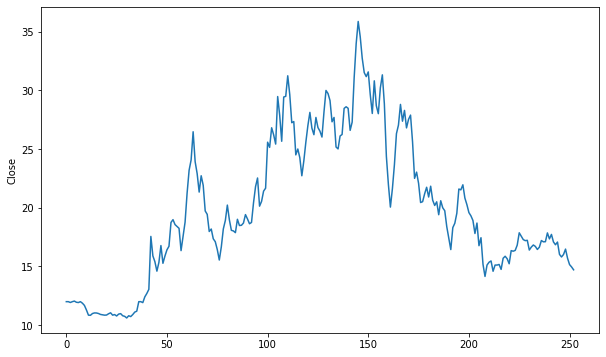

In [ ]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')
plt.show()

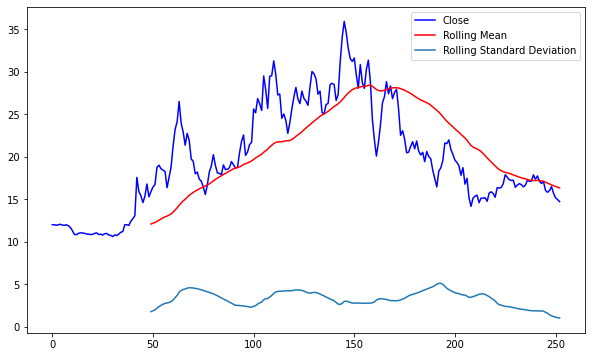

In [ ]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()
plt.show()

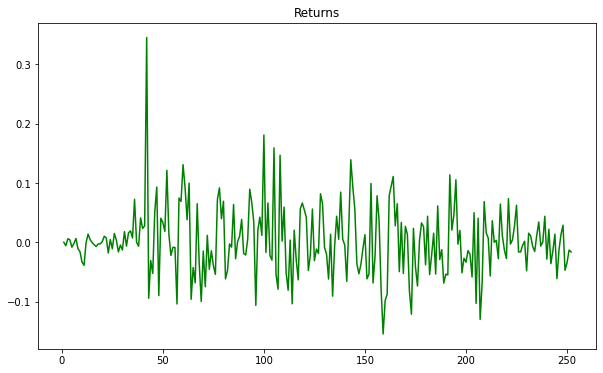

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")
plt.show()

In [ ]:
train = df_prices[:150]
test = df_prices[150:]
test

,Date,Open,High,Low,Close,Adj Close,Volume
150,2021-02-19,32.459999,33.480000,31.240000,31.580000,31.580000,8289700
151,2021-02-22,30.775000,30.870001,29.469999,29.629999,29.629999,7108600
152,2021-02-23,27.700001,28.860001,25.100000,28.040001,28.040001,13132500
153,2021-02-24,28.500000,30.820000,28.200001,30.820000,30.820000,9311000
154,2021-02-25,30.209999,31.650000,28.080000,28.700001,28.700001,11185900
...,...,...,...,...,...,...,...
248,2021-07-12,16.072001,16.680000,16.072001,16.480000,16.480000,5639200
249,2021-07-13,16.250000,16.459999,15.665000,15.700000,15.700000,6403800
250,2021-07-14,15.760000,15.830000,14.930000,15.160000,15.160000,7034800
251,2021-07-15,15.370000,15.480000,14.580000,14.960000,14.960000,7927200


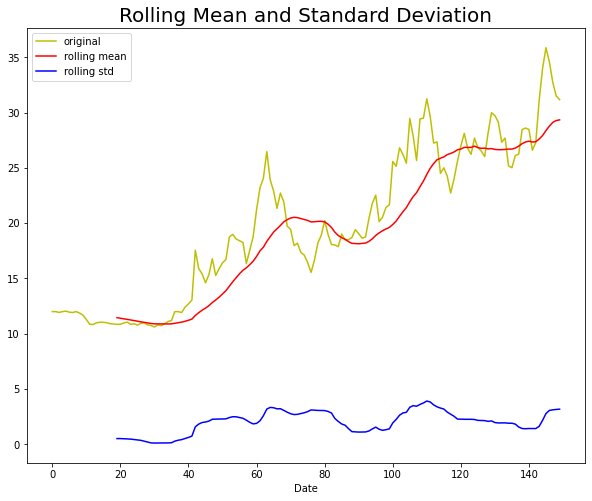

Results of dickey fuller test
(-0.3660603709966102, 0.9156131222090809, 6, 143, {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}, 460.2586875628788)


ADF Test Statistic : -0.3660603709966102
p-value : 0.9156131222090809
#Lags Used : 6
Number of Observations Used : 143
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 print(result)
 print("\n")
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

test_stationarity(train['Close'])

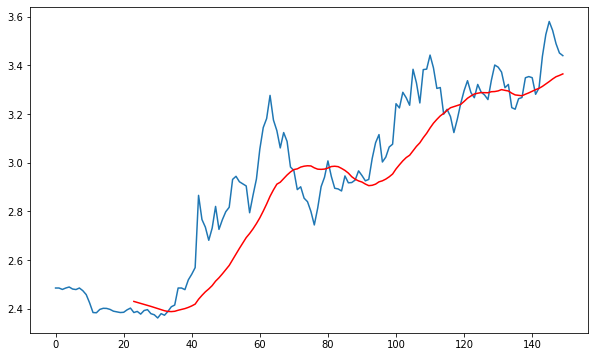

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 
plt.show()

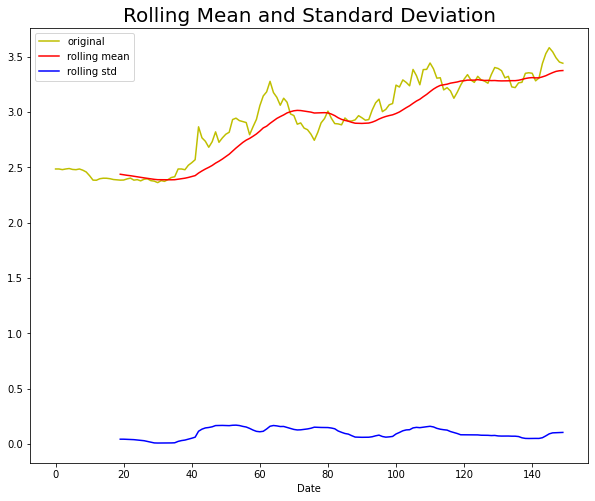

Results of dickey fuller test
(-0.6388621806123416, 0.861956799023778, 6, 143, {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}, -371.9581183407588)


ADF Test Statistic : -0.6388621806123416
p-value : 0.861956799023778
#Lags Used : 6
Number of Observations Used : 143
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)
test_stationarity(train_log)

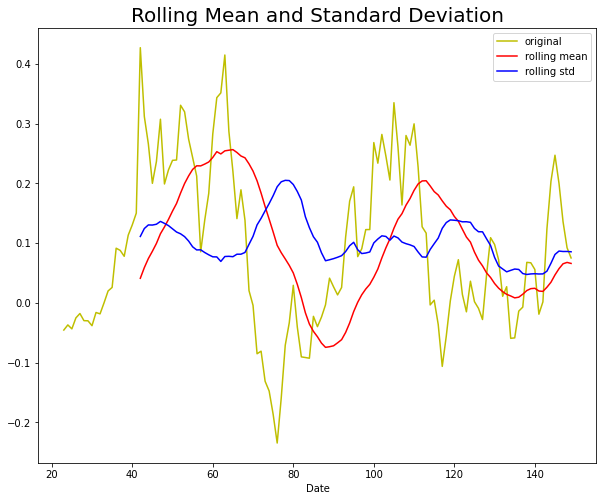

Results of dickey fuller test
(-2.724933002143477, 0.06982224950215724, 5, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, -299.38917891048686)


ADF Test Statistic : -2.724933002143477
p-value : 0.06982224950215724
#Lags Used : 5
Number of Observations Used : 121
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)
test_stationarity(train_log_diff)

In [ ]:
test_log

150    3.452524
151    3.388787
152    3.333632
153    3.428164
154    3.356897
         ...   
248    2.802148
249    2.753661
250    2.718660
251    2.705380
252    2.688867
Name: Close, Length: 103, dtype: float64

In [ ]:
#Using auto arima to make predictions using log data
#from pmdarima import auto_arima
model = ARIMA(train_log, order=(1,1,0))
model_fit = model.fit(disp=0)
fc, se, conf = model_fit.forecast(len(train_log),alpha=0.05)
fc
#print(model_fit.summary())
#model_fit.plot_predict()
#plt.show() 
#redictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])
#predictions

array([3.44576884, 3.4521636 , 3.45856799, 3.46497262, 3.47137725,
       3.47778187, 3.4841865 , 3.49059113, 3.49699576, 3.50340039,
       3.50980502, 3.51620965, 3.52261428, 3.52901891, 3.53542354,
       3.54182817, 3.54823279, 3.55463742, 3.56104205, 3.56744668,
       3.57385131, 3.58025594, 3.58666057, 3.5930652 , 3.59946983,
       3.60587446, 3.61227909, 3.61868371, 3.62508834, 3.63149297,
       3.6378976 , 3.64430223, 3.65070686, 3.65711149, 3.66351612,
       3.66992075, 3.67632538, 3.68273   , 3.68913463, 3.69553926,
       3.70194389, 3.70834852, 3.71475315, 3.72115778, 3.72756241,
       3.73396704, 3.74037167, 3.7467763 , 3.75318092, 3.75958555,
       3.76599018, 3.77239481, 3.77879944, 3.78520407, 3.7916087 ,
       3.79801333, 3.80441796, 3.81082259, 3.81722722, 3.82363184,
       3.83003647, 3.8364411 , 3.84284573, 3.84925036, 3.85565499,
       3.86205962, 3.86846425, 3.87486888, 3.88127351, 3.88767814,
       3.89408276, 3.90048739, 3.90689202, 3.91329665, 3.91970

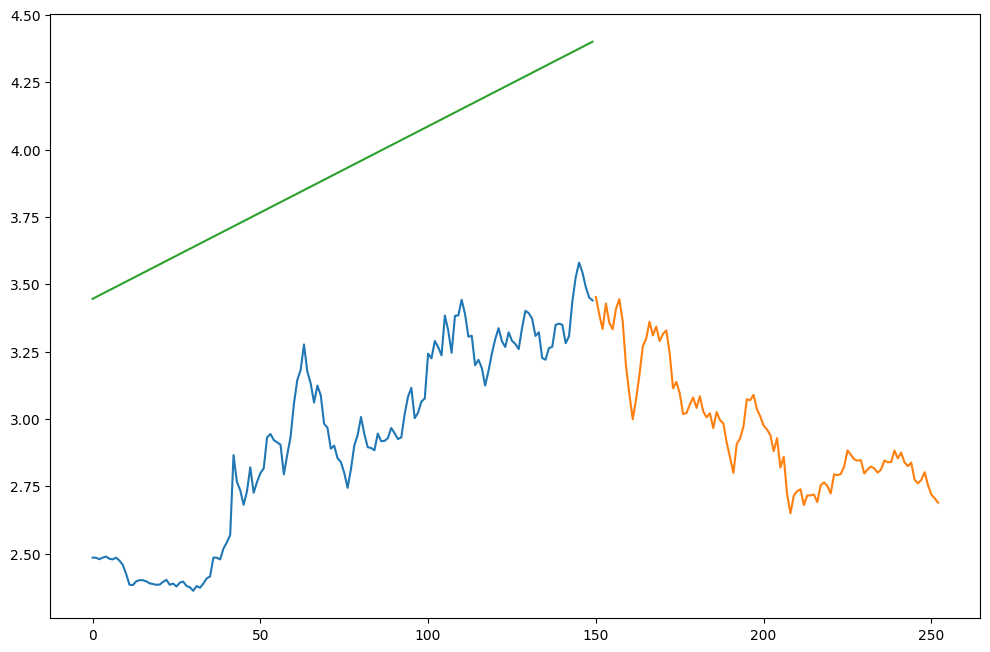

In [ ]:
#plt.plot(train_log, label='Train')
#plt.plot(test_log, label='Test')
#plt.plot(fc, label='Prediction')
#plt.title('OPEN Stock Price Prediction')
#plt.xlabel('Time')
#plt.ylabel('Actual Stock Price')
#plt.show()
#fc_series = pd.Series(fc)
plt.figure(figsize=(12,8), dpi=100)
plt.plot(train_log, label='training')
plt.plot(test_log, label='actual')
plt.plot(fc, label='forecast')
plt.show()

### TEXTUAL ANALYSIS

In [ ]:
df_news = pd.read_csv('india-news-headlines.csv',names = ['Date','Category','News'])
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
403311,20060405,city.mumbai,Daredevils foil robbery at Prabhadevi
403312,20060405,city.mumbai,Patil praises models for damage control
403313,20060405,city.mumbai,Tax on poll expenses: I-T informs EC
403314,20060405,world.rest-of-world,Future tense for Indian doctors in Britain


In [ ]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403315 entries, 1 to 403315
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    403315 non-null  object
 1   News    403314 non-null  object
dtypes: object(2)
memory usage: 9.2+ MB


In [ ]:
 #Converting data type of Date column 
 df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
 df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
403311,2006-04-05,Daredevils foil robbery at Prabhadevi
403312,2006-04-05,Patil praises models for damage control
403313,2006-04-05,Tax on poll expenses: I-T informs EC
403314,2006-04-05,Future tense for Indian doctors in Britain


In [ ]:
#Grouping the headlines for each day
df_news['News'] = df_news['News'].replace(np.nan,' ')
df_news['News'] = df_news.groupby(['Date']).transform(lambda x: ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
1873,2006-04-01,Latest B'wood gossip Sikhs want US prisoner's ...
1874,2006-04-02,Another blow for 29/10 blast orphan Centre thr...
1875,2006-04-03,'Missing' tourist may have gone on a trek Insu...
1876,2006-04-04,Overseas air fares stable during peak season I...


In [ ]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
1873    Latest B'wood gossip Sikhs want US prisoner's ...
1874    Another blow for 29/10 blast orphan Centre thr...
1875    'Missing' tourist may have gone on a trek Insu...
1876    Overseas air fares stable during peak season I...
1877    VTU to grant autonomy to colleges Arrack drink...
Name: News, Length: 1878, dtype: object

In [ ]:
#Cleaning headlines
c = []
ps  = PorterStemmer()
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [ ]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
1,2001-01-03,powerless north india grope dark think laxman ...
2,2001-01-04,string pull stephen hawk india vajpaye give bi...
3,2001-01-05,light combat craft take india club class hawk ...
4,2001-01-06,light combat craft take india club class hawk ...
...,...,...
1873,2006-04-01,latest b wood gossip sikh want us prison forc ...
1874,2006-04-02,anoth blow blast orphan centr throw book mcd d...
1875,2006-04-03,miss tourist may gone trek insur cover fight n...
1876,2006-04-04,oversea air fare stabl peak season iim c incre...


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
1873,2006-04-01,latest b wood gossip sikh want us prison forc ...,0.388259,0.114796
1874,2006-04-02,anoth blow blast orphan centr throw book mcd d...,0.463007,0.096841
1875,2006-04-03,miss tourist may gone trek insur cover fight n...,0.326166,0.116849
1876,2006-04-04,oversea air fare stabl peak season iim c incre...,0.542674,0.034928


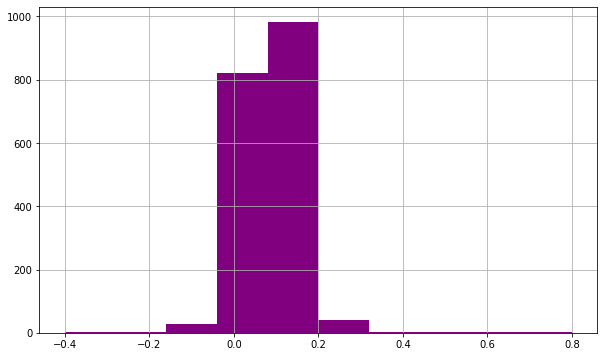

In [ ]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

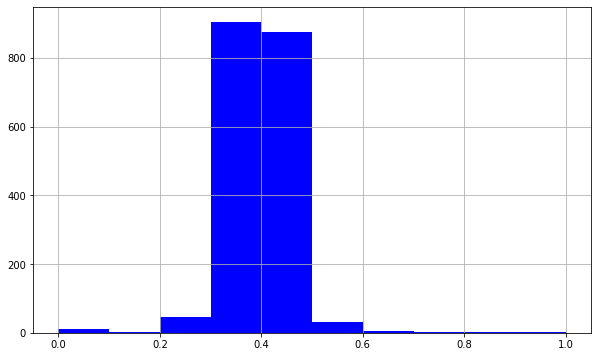

In [ ]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
1873,2006-04-01,latest b wood gossip sikh want us prison forc ...,0.388259,0.114796,-0.9735,0.130,0.778,0.091
1874,2006-04-02,anoth blow blast orphan centr throw book mcd d...,0.463007,0.096841,-0.8779,0.137,0.742,0.122
1875,2006-04-03,miss tourist may gone trek insur cover fight n...,0.326166,0.116849,-0.2263,0.114,0.761,0.124
1876,2006-04-04,oversea air fare stabl peak season iim c incre...,0.542674,0.034928,-0.9973,0.185,0.707,0.108
